In [9]:
from data_preprocessing import extract_accelerometer_data, csv_to_dataset_list, normate_dataset_period, extract_gyroscope_data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from sklearn.cluster import DBSCAN, KMeans
from scipy.stats import zscore
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
import json
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [27]:
ds = extract_accelerometer_data(r'/Users/raouldoublan/Documents/GitHub/Boxschlag-Klassifikation/data/Max_Gerade.csv')

with open('/Users/raouldoublan/Documents/GitHub/Boxschlag-Klassifikation/data/complete_smartpunch_dataset_7606punches.json', 'r') as f:
    smartpunch = json.load(f)

data_Kopf_Acc = extract_accelerometer_data(r'/Users/raouldoublan/Documents/GitHub/Boxschlag-Klassifikation/data/Max_Kopfhacken.csv')
data_Kinn_Acc = extract_accelerometer_data(r'/Users/raouldoublan/Documents/GitHub/Boxschlag-Klassifikation/data/Max_Kinnhacken.csv')
data_Ger_Gy = extract_gyroscope_data(r'/Users/raouldoublan/Documents/GitHub/Boxschlag-Klassifikation/data/Max_Gerade.csv')
data_Kinn_Gy = extract_gyroscope_data(r'/Users/raouldoublan/Documents/GitHub/Boxschlag-Klassifikation/data/Max_Kinnhacken.csv')
data_Kopf_Gy = extract_gyroscope_data(r'/Users/raouldoublan/Documents/GitHub/Boxschlag-Klassifikation/data/Max_Kopfhacken.csv')

data_Gemischt =extract_accelerometer_data(r'/Users/raouldoublan/Documents/GitHub/Boxschlag-Klassifikation/data/Max_Gemischt_01.csv')


In [4]:
#Funktionen

def plot_ds(ds):
    x, y, z = [], [], []
    ds_ = ds.to_dict('records')
    
    for ds_e in ds_:
        x.append(ds_e['x'])
        y.append(ds_e['y'])
        z.append(ds_e['z'])

    t = np.arange(0, len(x))
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(t, x, label='x-Achse')
    ax.plot(t, y, label='y-Achse')
    ax.plot(t, z, label='z-Achse')

    ax.set(xlabel='datastamps', ylabel='a (in m/s²)',
           title='lecker Daten')
    ax.grid()
    plt.legend()
    plt.show()
    '''''
    x_values = ds['x'].values
    plt.plot(x_values[400:450])
    plt.xlabel('Index')
    plt.ylabel('X Value')
    plt.title('Plot of X Values')
    plt.show()
    '''''

def plot_ds_1(ds):
    x, y, z = [], [], []
    ds_ = ds.to_dict('records')
    for ds_e in ds_:
        x.append(ds_e['x'])
        y.append(ds_e['y'])
        z.append(ds_e['z'])

    t = np.arange(0, len(x))

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(t, x, 'r.', label='x-Achse')
    ax.plot(t, y, 'b*', label='y-Achse')
    ax.plot(t, z, 'g^', label='z-Achse')

    ax.set(xlabel='Abtastwerte', ylabel='a (in m/s²)',
           title='Rohdaten eines Upper-Cuts')
    ax.grid()
    plt.legend()
    plt.show()
    
def interpolate_dataset(ds_el,sampling_rateNS = 0, interpolationKind='cubic'):
    # Funktioniert erst, wenn gelabelt und in raw-Form gebracht wurde

    the_cols = ['timestamp', 'x', 'y', 'z', 'label']
    data = []
    idxs = []
    sample_moment = 0
    idx = 0


    # stores the interpolating functions for each dataset element and axis
    f_x = (interp1d(ds_el['timestamp'].values.copy(), ds_el['x'].values.copy(), kind=interpolationKind,
                    bounds_error=False, fill_value=(ds_el['x'][0].copy(), ds_el['x'][0].copy())))
    f_y = (interp1d(ds_el['timestamp'].values.copy(), ds_el['y'].values.copy(), kind=interpolationKind,
                    bounds_error=False, fill_value=(ds_el['y'][0].copy(), ds_el['y'][0].copy())))
    f_z = (interp1d(ds_el['timestamp'].values.copy(), ds_el['z'].values.copy(), kind=interpolationKind,
                    bounds_error=False, fill_value=(ds_el['z'][0].copy(), ds_el['z'][0].copy())))

    while sample_moment < ds['timestamp'].values[-1]:
        data.append([float(f_x(sample_moment).copy()), float(f_y(sample_moment).copy()), float(f_z(sample_moment).copy()), int(
                   # dataset_raws_storer.append([5.3, 5.3, 5.3, int(
                   sample_moment), ds_el['label'][0]])
        sample_moment += sampling_rateNS/2
        idxs.append(idx)
        idx += 1

    print(idx)
    ds_interp = pd.DataFrame(data, columns=the_cols, index=idxs)

    return ds_interp

def interpolate_dataset_1(ds_el,sampling_rateNS = 0, interpolationKind='cubic'):

    f_x = (interp1d(ds_el['timestamp'].values.copy(), ds_el['x'].values.copy(), kind=interpolationKind,
            bounds_error=False, fill_value=(ds_el['x'][0].copy(), ds_el['x'][0].copy())))
    f_y = interp1d(ds_el['timestamp'].values.copy(), ds_el['y'].values.copy(), kind=interpolationKind)
    f_z = interp1d(ds_el['timestamp'].values.copy(), ds_el['z'].values.copy(), kind=interpolationKind)

    return f_x

def auto_labeling(data, axis, height, distance, label):
    """
    Args:
        label: 1 ist Gerade, 2 ist Kinnhacken, 3 ist Kopfhacken
        
    Returns:
    """
    # liste mit Schlägen
    punches = []
    
    # df mit den Hochpunkten
    p = scipy.signal.find_peaks(data[axis], height=height, distance=distance)
    peaks = data.iloc[p[0]]
    
    # eine Spalte mit den Indizes der Hochpunkte wird erstellt
    peaks = peaks.reset_index()
    
    # start and endpoint of punches
    start = 0
    end = 0
    
    first_iteration = True
    
    for idx,row in peaks.iterrows():
        if first_iteration:
            start = 0
            end = (peaks.loc[1, 'index'] + peaks.loc[0, 'index'])//2
            first_iteration = False
        elif idx == len(peaks)-1:
            start = (peaks.loc[idx-1, 'index'] + peaks.loc[idx, 'index'])//2
            end = len(data)
        else:
            start = (peaks.loc[idx-1, 'index'] + peaks.loc[idx, 'index'])//2
            end = (peaks.loc[idx, 'index'] + peaks.loc[idx+1, 'index'])//2
        
        # Label the data from start to end
        ds = data_to_raw(data[start:end], label)
        punches.append(ds)
        
    return punches

def data_to_raw(data, label):
    data = data.reset_index()
    periodNS = data.loc[len(data)-1, 'timestamp'] - data.loc[0, 'timestamp']
    # create raws
    raws = []
    for idx, row in data.iterrows():
        raw = {'_id': idx, 'timestamp': row['timestamp'], 'x': row['x'], 'y': row['y'], 'z': row['z']}
        raws.append(raw)

    # insert raws into dataset
    one_punch = {'label': label, 'count': len(data), 'periodNS': periodNS ,'raws': raws}

    return one_punch


In [5]:
# Spielwiese
data
p = scipy.signal.find_peaks(data[axis], height=height, distance=distance)
peaks = data.iloc[p[0]]
    
# eine Spalte mit den Indizes der Hochpunkte wird erstellt
peaks = peaks.reset_index()


def reduce_dimensionality(data, n_components):
    pca = PCA(n_components=n_components)
    data = StandardScaler().fit_transform(data)
    data = pca.fit_transform(data)
    return data


{'label': 2, 'count': 805, 'periodNS': 8014752499.999303, 'raws': [{'_id': 0, 'timestamp': 5482736624.999234, 'x': 0.739593505859375, 'y': 0.3588104248046875, 'z': -0.5629730224609375}, {'_id': 1, 'timestamp': 5492705624.998053, 'x': 0.728118896484375, 'y': 0.300811767578125, 'z': -0.555084228515625}, {'_id': 2, 'timestamp': 5502673625.000171, 'x': 0.73565673828125, 'y': 0.2602691650390625, 'z': -0.55535888671875}, {'_id': 3, 'timestamp': 5512642624.998989, 'x': 0.740020751953125, 'y': 0.2610015869140625, 'z': -0.5699615478515625}, {'_id': 4, 'timestamp': 5522611624.9978075, 'x': 0.7386322021484375, 'y': 0.2683563232421875, 'z': -0.58233642578125}, {'_id': 5, 'timestamp': 5532579624.999926, 'x': 0.72607421875, 'y': 0.2563934326171875, 'z': -0.5607452392578125}, {'_id': 6, 'timestamp': 5542548624.998744, 'x': 0.7158966064453125, 'y': 0.2168121337890625, 'z': -0.5240020751953125}, {'_id': 7, 'timestamp': 5552516624.997225, 'x': 0.7253570556640625, 'y': 0.1752471923828125, 'z': -0.5014495

In [44]:
# PCA Tests
data = data_Kinn_Gy[['x', 'y', 'z']].copy()
data_Kopf = data_Ger_Gy[['x', 'y', 'z']].copy()
data_Ger = data_Kopf_Gy[['x', 'y', 'z']].copy()
data_2 = data_Kinn_Acc[['timestamp']].copy()

features = ['x', 'y', 'z']

# Separating out the features
#x = data.loc[:, features].values

# Separating out the target
#y = data.loc[:,['target']].values

# Standardizing the features
x = StandardScaler().fit_transform(data)
y = StandardScaler().fit_transform(data_Kopf)
z = StandardScaler().fit_transform(data_Ger)

pca = PCA(n_components=1)

a = pca.fit_transform(x)
b = pca.fit_transform(y)
c = pca.fit_transform(z)

df_1 = pd.DataFrame(data = a, columns = ['one_value'])
df_2 = pd.DataFrame(data = b, columns = ['one_value'])
df_3 = pd.DataFrame(data = c, columns = ['one_value'])

finalDf_1 = pd.concat([df_1,data_2], axis = 1)
finalDf_2 = pd.concat([df_2,data_2], axis = 1)
finalDf_3 = pd.concat([df_3,data_2], axis = 1)

finalDf_1 = finalDf_1[550:1500]
finalDf_2 = finalDf_2[550:1500]
finalDf_3 = finalDf_3[550:1500]

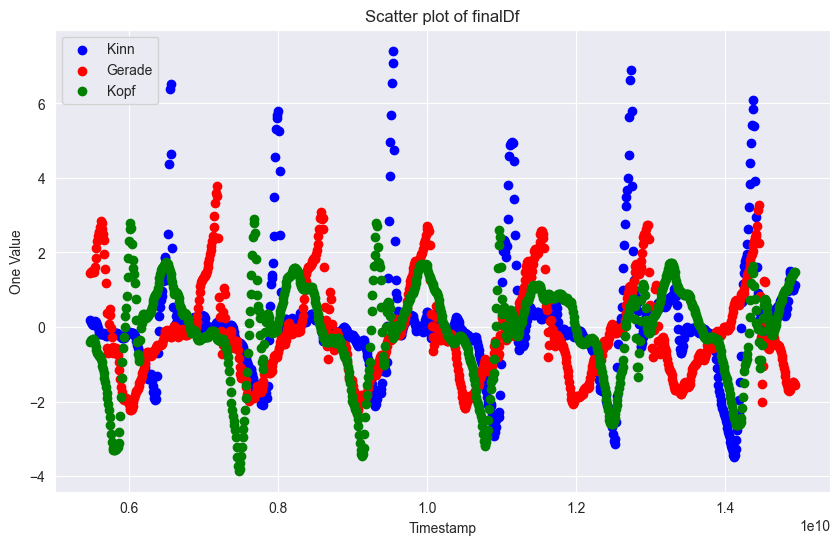

In [45]:
# PCA Visualisierung
plt.figure(figsize=(10,6))
plt.scatter(finalDf_1['timestamp'], finalDf_1['one_value'], c='blue')
plt.scatter(finalDf_2['timestamp'], finalDf_2['one_value'], c='red')
plt.scatter(finalDf_3['timestamp'], finalDf_3['one_value'], c='green')
plt.title('Scatter plot of finalDf')
plt.xlabel('Timestamp')
plt.ylabel('One Value')
plt.legend(['Kinn', 'Gerade', 'Kopf'])
plt.show()      


In [6]:
df = data_Kinn_Acc
x = scipy.signal.find_peaks(df['y'], height=5.5, distance=150)
print(len(x[0]))

100


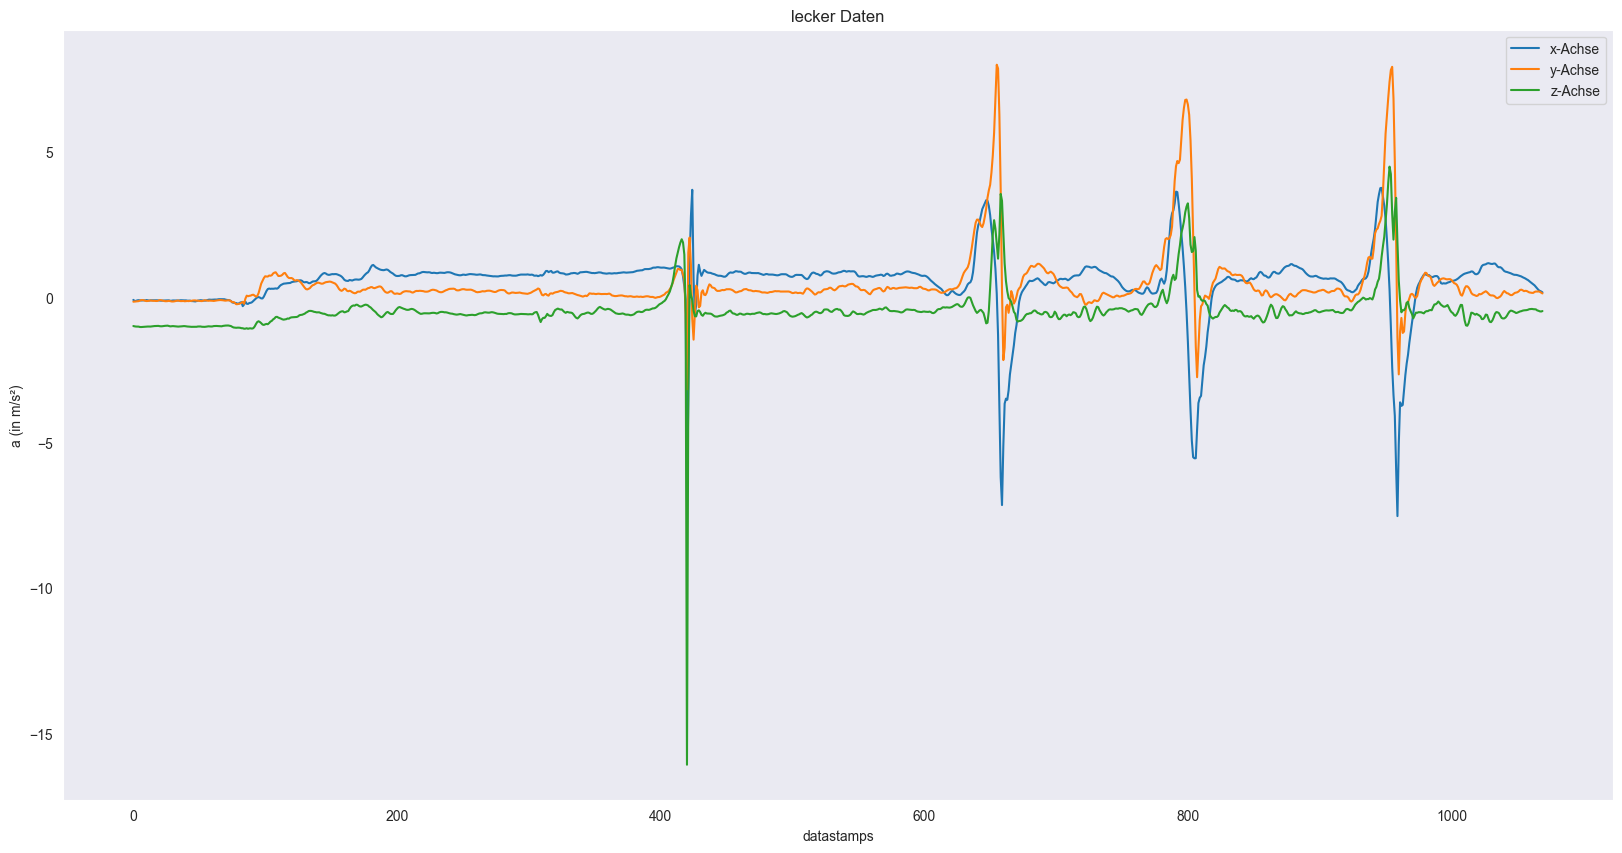

In [7]:
plot_ds(data_Kinn_Acc[0:1070])

          timestamp         x         y         z
655    6.529441e+09  0.142105  8.014618  1.848343
955    9.520024e+09 -2.383743  7.942474  2.884125
1113   1.109506e+10 -1.339783  7.826004  2.682144
1273   1.269004e+10 -1.463287  7.089508  4.322342
1438   1.433485e+10 -1.065338  6.215149  3.710297
...             ...       ...       ...       ...
18618  1.855928e+11 -5.098999  7.466812  4.530045
18815  1.875566e+11 -5.140747  8.412003  4.611053
18998  1.893808e+11 -5.012222  7.086975  4.915466
19186  1.912549e+11 -5.162003  7.866333  5.249954
19397  1.933583e+11 -8.796173  8.160461  6.949570

[100 rows x 4 columns]


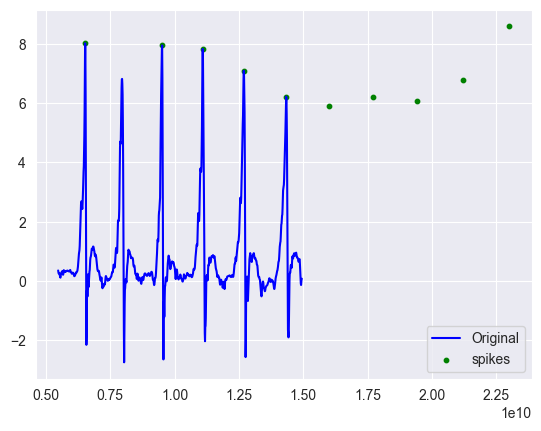

In [8]:
#Spielwiese1
#complete the function auto_labeling in the following way: the function should save the peak points of the x axis in a list.
p = scipy.signal.find_peaks(data_Kinn_Acc['y'], height=5.5, distance=150)
spikes = data_Kinn_Acc.iloc[p[0]]
ds_e = data_Kinn_Acc[550:1500]
print(spikes)
spikes_small = spikes[0:10]
#f_x = interpolate_dataset_1(ds_e)
#timestamps = np.linspace(ds_e['timestamp'].min(), ds_e['timestamp'].max(), len(ds_e))
#interpolated_values = f_x(timestamps)
plt.plot(ds_e['timestamp'], ds_e['y'], "blue", label="Original")
plt.scatter(spikes_small['timestamp'], spikes_small['y'], 10, "green", label="spikes")
#plt.plot(ds_e['timestamp'], interpolated_values, "red", label="Interpolated")
plt.legend()
plt.show()

          timestamp         x         y         z
0      0.000000e+00 -0.059662 -0.098602 -0.960510
1      9.969000e+06 -0.021240 -0.115128 -0.966843
2      1.993800e+07 -0.059235 -0.121017 -0.965866
3      2.990700e+07 -0.051376 -0.108932 -0.978439
4      3.987600e+07 -0.038437 -0.100632 -0.986923
...             ...       ...       ...       ...
37330  2.411030e+12  0.154922  0.034882 -0.990097
37331  2.411040e+12  0.158401  0.039139 -1.000916
37332  2.411050e+12  0.187042  0.060272 -1.005325
37333  2.411060e+12  0.251175  0.134598 -1.000458
37334  2.411070e+12  0.224167 -0.027634 -1.011948

[37335 rows x 4 columns]


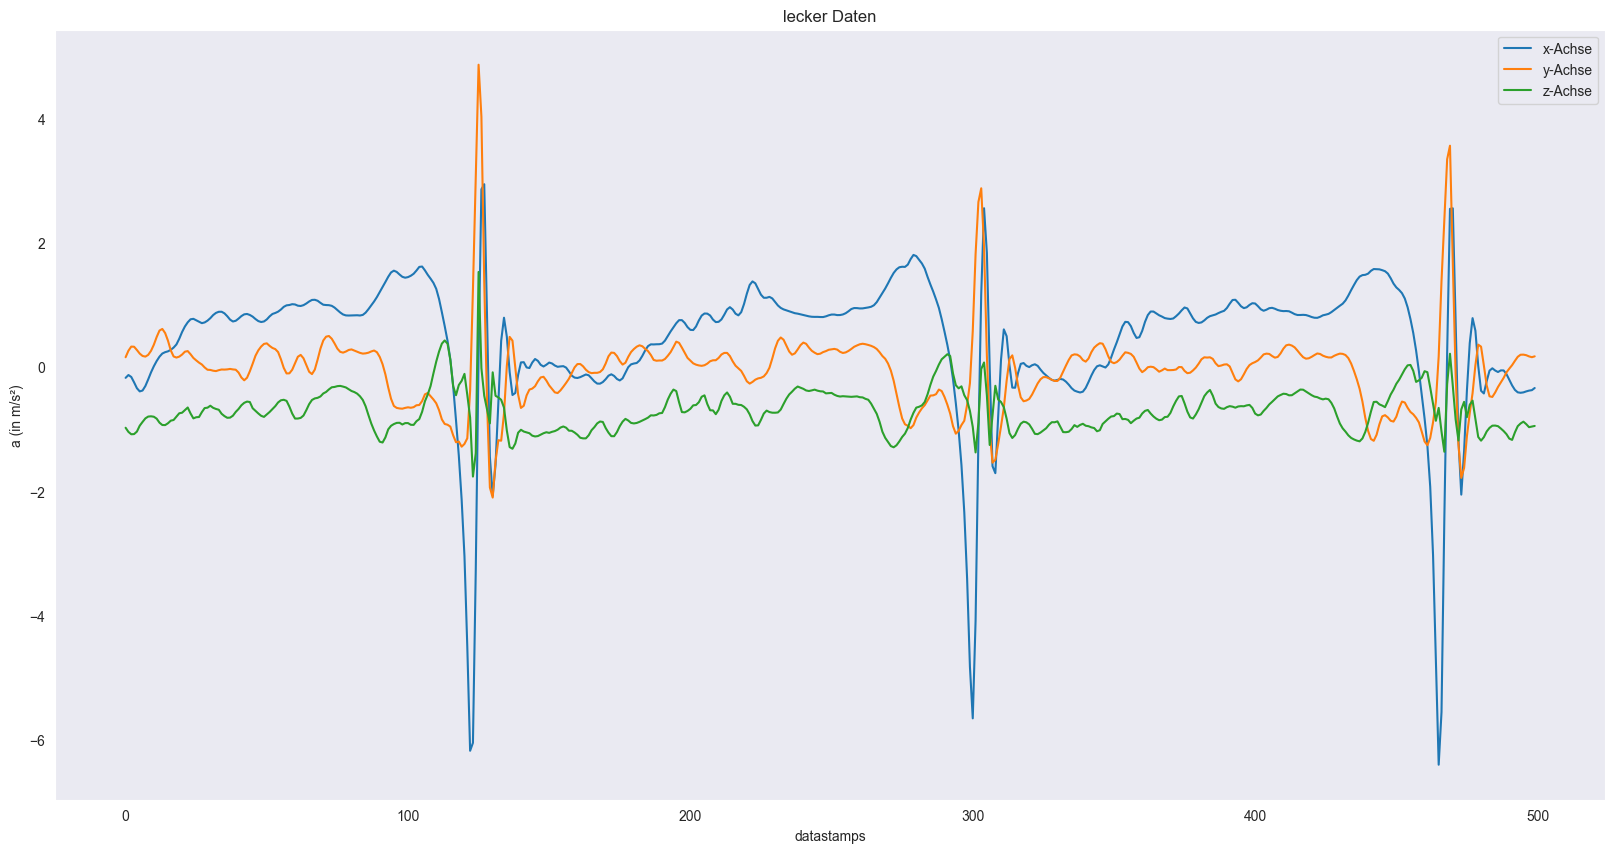

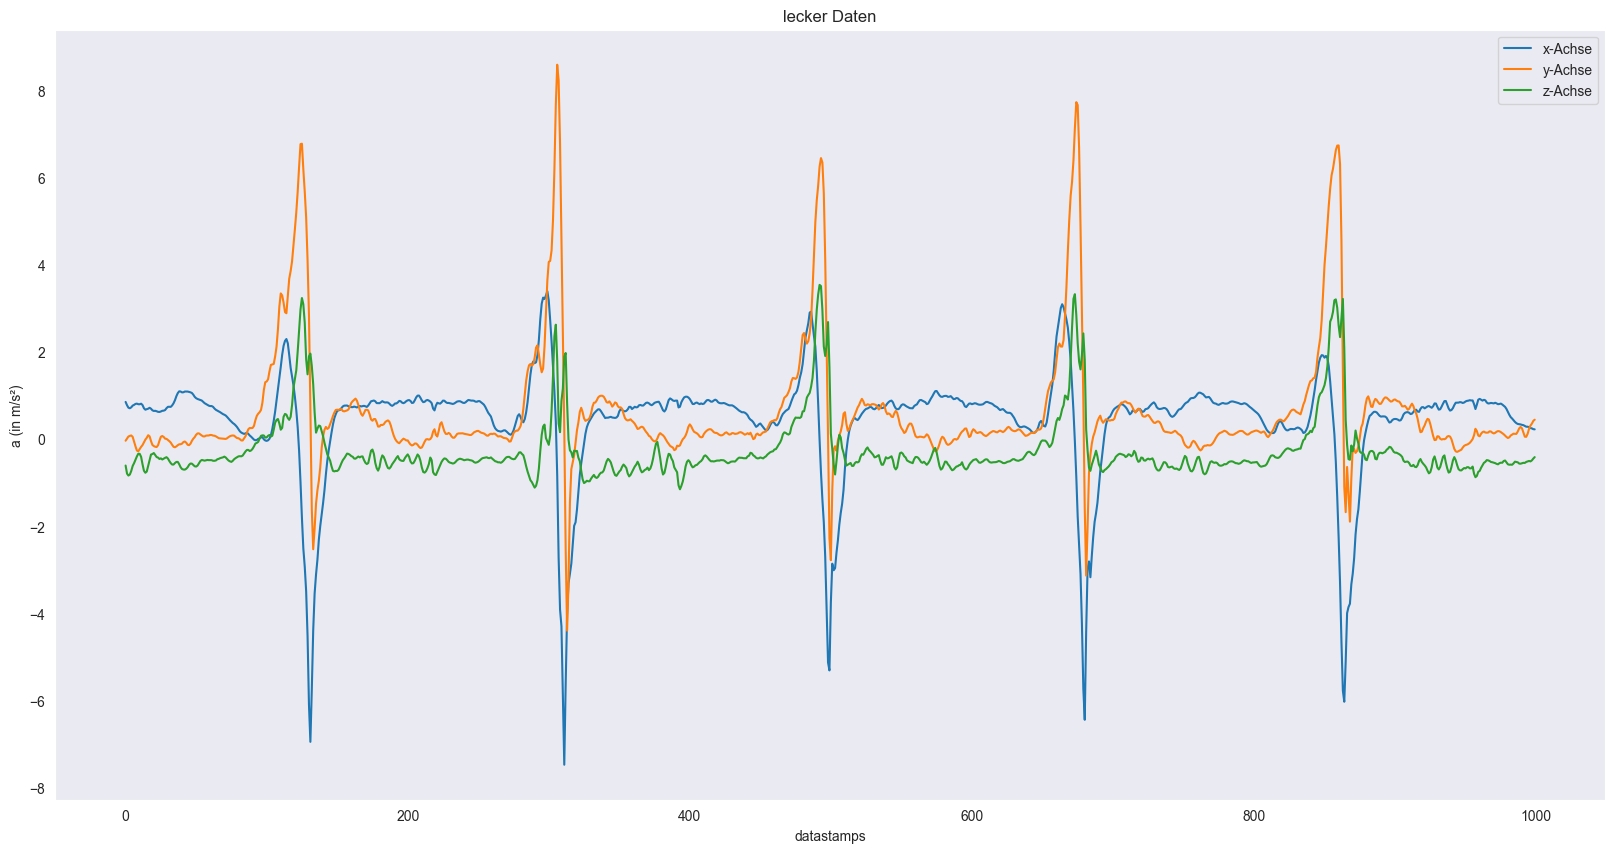

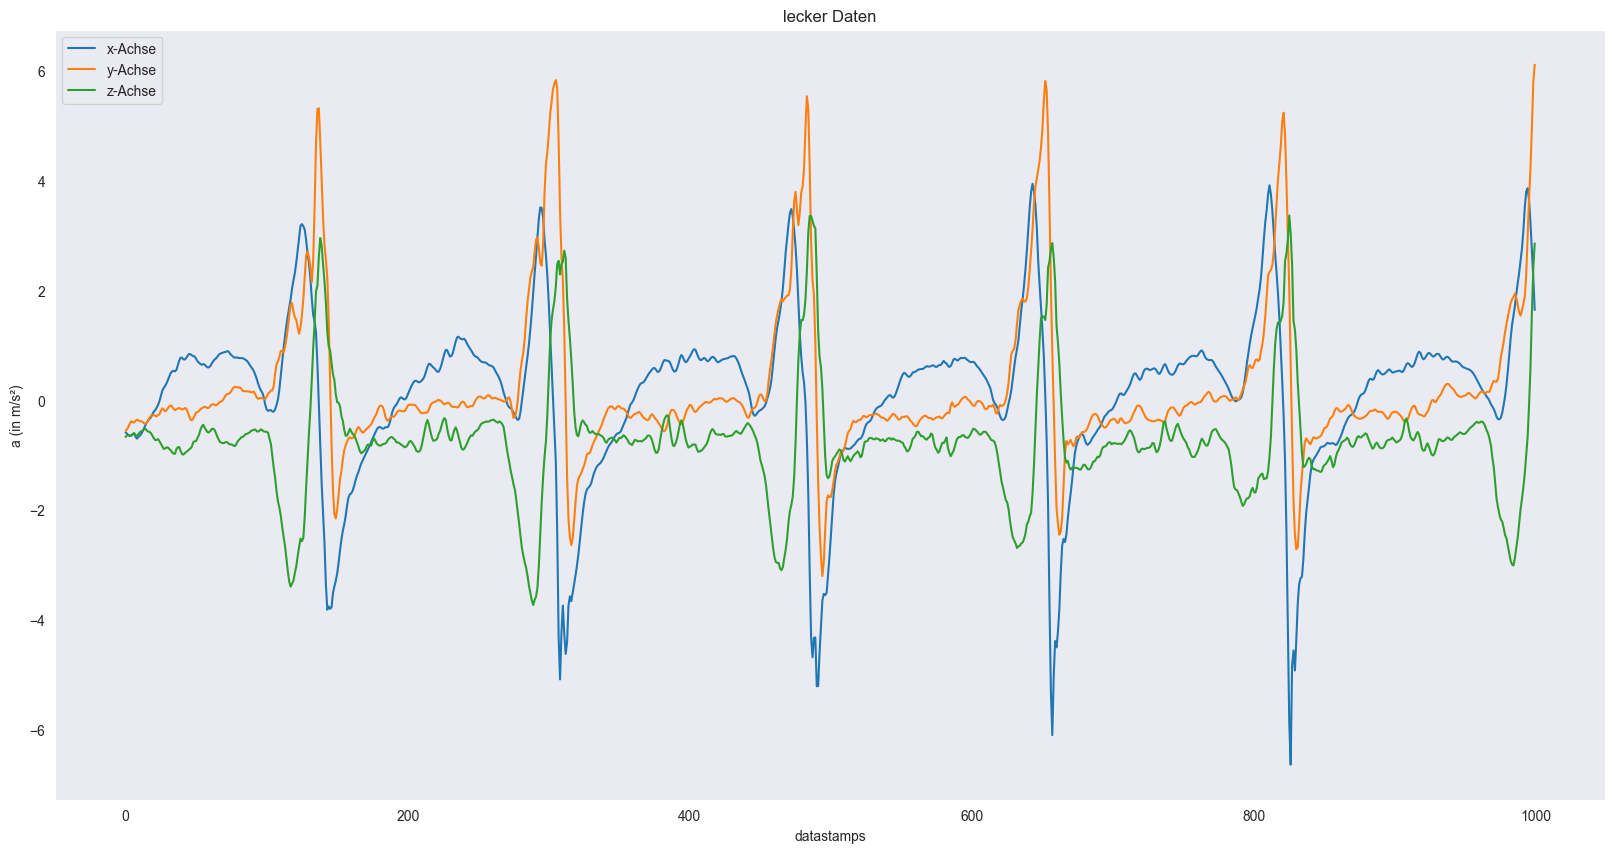

In [9]:
#Spielwiese2
#print(ds)
plot_ds(ds[2000:2500])
plot_ds(data_Kinn_Acc[2000:3000])
plot_ds(data_Kopf_Acc[2000:3000])

In [ ]:
plot_ds(data_Ger_Gy[2000:3000])
plot_ds(data_Kinn_Gy[2000:3000])
plot_ds(data_Kopf_Gy[2000:3000])

In [ ]:
df = pd.DataFrame(
{"a" : [4, 8, 6],
"b" : [7, 8, 9],
"c" : [10, 11, 12]},
index = [1, 2, 3])

print(df)

In [ ]:
df.sort_values(by='a', ascending=False, inplace=True)
print(df)
max_value_index = df['a'].idxmax()
print(max_value_index)
max_value_row = df.loc[max_value_index]
print(max_value_row)

In [ ]:
# DB-Scan test
data = data_Gemischt[['x', 'y', 'z']].copy()
db = DBSCAN(eps=1, min_samples=10).fit(data)

# Get labels (note that noisy samples are labeled as -1)
labels = db.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a colormap
cmap = plt.get_cmap("viridis")

# Plot each cluster
for cluster_number in set(labels):
    cluster = data[labels == cluster_number]
    ax.scatter(cluster['x'], cluster['y'], cluster['z'], alpha=0.6, edgecolors='w', s=60, label=f'Cluster {cluster_number}', cmap=cmap(cluster_number / len(set(labels))))

ax.legend()

In [ ]:
data = data_Gemischt[['y','z']].copy()
data_2 = auto_labeling(data_Gemischt, 5.5, 170)

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

plt.scatter(data['y'], data['z'], c=labels, cmap='viridis')

# plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='red')
plt.show()


In [ ]:
# Spielwiese
print(smartpunch[0].keys())
